In [35]:
import pandas as pd
import vcfpy
from SigProfilerAssignment import Analyzer as Analyze
import musical
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import shutil
import ast
from tqdm import tqdm 
import re
import sys
from scipy import stats
from contextlib import redirect_stdout
from tabulate import tabulate
import csv
from scipy.stats import linregress
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import odr
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import matplotlib as mpl
import logging
logging.getLogger().setLevel(logging.WARNING)

pd.options.mode.chained_assignment = None  # Disable the warning

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 13  

pd.set_option("display.max_columns", None)
%matplotlib inline

In [21]:
def G(df):
    n = len(df)
    sum_pi = 0
    sum_den = 0 
    for index, row in df.iterrows(): 
        sum_den += row['prob_SBS1'] * row['MutCN'] / (row['MajCN'] + row['MinCN'])  
        sum_pi += row['prob_SBS1']
    G = sum_pi / sum_den
    return G

def read_vcf(record):
    return {
        "Chromosome": record.CHROM,
        "Position": record.POS,
        "ID": record.ID,
        "Reference Allele": record.REF,
        "Alternate Alleles": record.ALT,
        "Quality Score": record.QUAL,
        "Info": record.INFO
    }

def dict_to_vcf_INFO(d):
    parts = []
    for k, v in d.items():
        if isinstance(v, list):
            v_str = ','.join(str(i) for i in v)
        else:
            v_str = str(v)
        parts.append(f"{k}:{v_str}")
    return ';'.join(parts)

def INFO_field_to_dict(s):
    d = {}
    for item in s.split(';'):
        if not item:
            continue
        key, val = item.split(':', 1)
        if ',' in val:
            val_list = val.split(',')
            # Try to infer types (int, float)
            try:
                val_list = [x for x in val_list]
            except:
                pass
            d[key] = val_list
        else:
            # Try to infer scalar types
            if val == 'TRUE':
                d[key] = True
            elif val == 'FALSE':
                d[key] = False
            else:
                try:
                    d[key] = int(val)
                except ValueError:
                    try:
                        d[key] = float(val)
                    except ValueError:
                        d[key] = val
    return d

def vcf_to_dataframe(vcf_file):
    data = []
    with open(vcf_file, 'r') as f:
        reader = vcfpy.Reader.from_stream(f)
        for record in reader:
            data.append(read_vcf(record))
    return pd.DataFrame(data)

def dataframe_to_vcf(dataframe, output_vcf):
    # Select columns up to and including 'INFO'
    selected_columns = dataframe.columns[:dataframe.columns.get_loc('INFO')+1]
    dataframe_selected = dataframe[selected_columns].copy()

    # Apply dict_to_INFO_field to the 'INFO' column
    dataframe_selected['INFO'] = dataframe_selected['INFO'].apply(dict_to_vcf_INFO)

    # Write header to VCF file
    header = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tINFO\n"
    with open(output_vcf, 'w') as vcf:
        vcf.write(header)

    # Append DataFrame to VCF file in VCF format
    dataframe_selected.to_csv(output_vcf, sep="\t", mode='a', index=False, header=False)

def process_vcf_dataframe(df, time_analysis=False):
    # Rename columns to match the VCF format
    df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'INFO']
    #sample['INFO'] = sample['INFO'].apply(INFO_field_to_dict)
    df['ID'] = df['ID'].apply(lambda x: x[0] if len(x) != 0 else '.')
    df['ALT'] = df['ALT'].apply(lambda x: x[0].value)

    # Helper to extract INFO fields with a default value of '.'
    def extract_info_field(info, field, default='.'):
        return info.get(field, default)

    # Extract relevant fields from INFO
    info_fields = ['MajCN', 'MinCN', 'MutCN', 'context', 'CLS', 'inWGDregion', 'powr']
    for field in info_fields:
        df[field] = df['INFO'].apply(lambda info: extract_info_field(info, field))

    # Clean 'CLS' column
    df['CLS'] = df['CLS'].apply(lambda x: ''.join(re.findall(r"\[(.+?)\]", x)))

    # Filter rows based on conditions
    df = df[(df['context'] != '.') & (df['CLS'] != '')]
    
    # Filtering for timing analysis
    if time_analysis:
        df = df[df['MajCN'] == 2]
        df = df[df['inWGDregion'] == 'TRUE']

    df.rename(columns={'powr': 'pow'}, inplace=True)

    return df

def process_vcfs_early_late(input_folder, output_folder, organ_csv_path, time_analysis=False, verbose=False):
    """
    Process all VCF files in the input folder and save the processed files in the output folder.

    Args:
    - input_folder (str): Path to the folder containing VCF files.
    - output_folder (str): Path to the folder where processed VCF files will be saved.
    - organ_csv_path (str): Path to the CSV file containing organ information.
    - time_analysis (bool): If True, create a 'timing' folder; otherwise, create 'all_mut' folder.
    """
    
    organ_df = pd.read_csv(organ_csv_path)
    organ_lookup = organ_df.set_index('aliquot_id')['organ'].to_dict()

    # Predefine output folders for each organ and CLS type
    organ_folders = {
        organ: {
            "timing" if time_analysis else "all_mut": os.path.join(output_folder, organ, "timing" if time_analysis else "all_mut"),
            "Early": os.path.join(output_folder, organ, "timing" if time_analysis else "all_mut", "Early"),
            "Late": os.path.join(output_folder, organ, "timing" if time_analysis else "all_mut", "Late"),
            "NA": os.path.join(output_folder, organ, "timing" if time_analysis else "all_mut", "NA")
        }
        for organ in organ_df['organ'].unique()
    }
    
    # Create all required folders
    for folders in organ_folders.values():
        for folder in folders.values():
            os.makedirs(folder, exist_ok=True)

    # Process VCF files in the input folder
    for filename in tqdm([f for f in os.listdir(input_folder) if f.endswith(".vcf")], desc="Processing VCFs"):
        vcf_path = os.path.join(input_folder, filename)
        aliquot_id = filename.split(".")[0]
        organ = organ_lookup.get(aliquot_id)

        if not organ:
            #print(f"Organ information not found for {filename}, skipping.")
            continue

        # Process VCF
        sample = vcf_to_dataframe(vcf_path)
        if time_analysis:
            sample = process_vcf_dataframe(sample, time_analysis=True)
        else:
            sample = process_vcf_dataframe(sample)

        cls_groups = {
            "Early": sample[sample['CLS'] == 'early'],
            "Late": sample[sample['CLS'] == 'late'],
            "NA": sample[sample['CLS'] == 'NA']
        }

        for cls, df in cls_groups.items():
            if not df.empty:
                output_vcf = os.path.join(organ_folders[organ]["timing" if time_analysis else "all_mut"], cls, f"{aliquot_id}_{cls.lower()}.vcf")
                dataframe_to_vcf(df, output_vcf)

def save_probabilities(H_reduced_normalized, W_reduced, output_dir):
    # Create a directory to store probability files if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    for col_name in H_reduced_normalized.columns:
        # Create an empty DataFrame with the dimensions of W
        result = pd.DataFrame(np.zeros((1, len(W_reduced.columns))), columns=W_reduced.columns)
        col_to_multiply = H_reduced_normalized[col_name]

        # Perform element-wise multiplication for each row in W with the selected column from H
        result = W_reduced.mul(col_to_multiply, axis=1)
        probabilities = result.div(result.sum(axis=1), axis=0)

        output_file = os.path.join(output_dir, f'prob_{col_name}.txt')
        probabilities.to_csv(output_file, sep='\t', index=True)

def calculate_exposures(activities_file, mutation_file, tumor_type, output_folder):
    """
    Process data and run the MuSiCal algorithm, then save the results as CSV files.
    
    Args:
    - activities_file (str): Path to the activities file (CSV format).
    - mutation_file (str): Path to the mutation file (CSV format).
    - tumor_type (str): Tumor type for restricting the catalog.
    - parent_folder (str): Path to the parent folder where CSV files will be saved.
    
    Returns:
    - exposures (DataFrame): The exposures dataframe from SigProfiler.
    - H1 (DataFrame): The exposures dataframe from MuSiCal naive method.
    - H2 (DataFrame): The exposures dataframe from MuSiCal likelihood method.
    - model2.H_reduced_normalized (DataFrame): The normalized exposures from MuSiCal likelihood reduced model.
    """
    
    # Read Activities file
    exposures = pd.read_csv(activities_file, delimiter='\t', index_col=0)
    colnames = exposures.index.tolist()
    exposures = exposures.T
    exposures.columns = colnames
 
    mutation_matrix = pd.read_csv(mutation_file, delimiter='\t', index_col=0)
    numeric_cols = mutation_matrix.select_dtypes(include=['number']).columns
    numeric_cols_filtered = [col for col in numeric_cols if not all(mutation_matrix[col] == 0)]

    mutation_matrix = mutation_matrix[numeric_cols_filtered]
    
    # Musical
    catalog = musical.load_catalog('COSMIC_v3p2_SBS_WGS')
    catalog.restrict_catalog(tumor_type=tumor_type, is_MMRD=False, is_PPD=False)
    W = catalog.W

    # Refit with different methods
    W = W.reindex(mutation_matrix.index)

    H1, model1 = musical.refit.refit(mutation_matrix, W, method='thresh_naive', thresh=0)
    H1.columns = colnames

    H2, model2 = musical.refit.refit(mutation_matrix, W, method='likelihood_bidirectional', thresh=0.001)
    H2.columns = colnames

    # Create the parent folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Save the DataFrames to CSV files within the parent folder
    exposures.to_csv(os.path.join(output_folder, "exposures_SigProfiler.csv"))
    H1.to_csv(os.path.join(output_folder, "exposures_MuSiCal_naive.csv"))
    H2.to_csv(os.path.join(output_folder, "exposures_MuSiCal_lik.csv"))
    model2.H_reduced_normalized.to_csv(os.path.join(output_folder, "exposures_MuSiCal_lik_reduced_norm.csv"))
    model2.W_reduced.to_csv(os.path.join(output_folder, "W_MuSiCal_lik_reduced_norm.csv"))

    return model2.H_reduced_normalized, model2.W_reduced

def run_Signature_Analysis(parent_folder, genome_build):
    """
    Perform COSMIC FIT analysis and MuSiCal analysis for each subfolder in the given parent folder.
    
    Args:
    - parent_folder (str): Path to the parent folder that contains subfolders 'Early', 'Late', 'NA'.
    """
    subfolders = ['Early', 'Late', 'NA']
    
    # Iterate through subfolders
    for subfolder in subfolders:
        subfolder_path = os.path.join(parent_folder, subfolder)
        output_path = os.path.join(parent_folder, subfolder + '/Alexandrov/')
        
        Analyze.cosmic_fit(subfolder_path, output_path,
                                   input_type="vcf", context_type="96",
                                   collapse_to_SBS96=False, cosmic_version=3.2, exome=False,
                                   genome_build=genome_build,
                                   signature_database='breast_sig_db.txt',
                                   exclude_signature_subgroups=None, export_probabilities=False,
                                   export_probabilities_per_mutation=False, make_plots=False,
                                   sample_reconstruction_plots=False, verbose=False)

        # Process data and run musical for the subfolder
        H_reduced_normalized, W_reduced = calculate_exposures(
            os.path.join(output_path, 'Assignment_Solution/Activities/Assignment_Solution_Activities.txt'),
            os.path.join(parent_folder, subfolder + '/output/SBS/Input_vcffiles.SBS96.all'),
            tumor_type='Breast.AdenoCA',
            output_folder=os.path.join(parent_folder, 'SignatureFitting', subfolder, 'exposures')
        )

        # Apply save_probabilities function
        save_probabilities(H_reduced_normalized, W_reduced, 
                           output_dir=os.path.join(parent_folder, 'SignatureFitting', subfolder, 'probabilities'))
        
def prepare_samples_for_timing(vcf_folder_path):
    """
    Reads SNV files from the specified folder path, extracts SBS96 information,
    and adds corresponding information from probabilities based on SBS96 as well as
    MutCN, MinCN, MajCN values.

    Parameters:
        vcf_folder_path (str): Path to the folder containing SNV files (VCFs).

    Returns:
        dict or None: Dictionary of DataFrames containing SBS96 information and added probabilities,
                      where keys are sample IDs and values are DataFrames,
                      if valid files are found, otherwise returns None.
    """
    # Initialize an empty dictionary to store DataFrames for each sample
    sample_dfs = {}

    # Iterate over each subfolder
    for subfolder in ['Early', 'Late', 'NA']:
        print(f'Processing {subfolder} samples:')
        subfolder_path = os.path.join(vcf_folder_path, subfolder)
        if os.path.exists(subfolder_path):
            # Use list comprehension to get the VCF files within the subfolder
            files_to_process = [filename for filename in os.listdir(subfolder_path) if filename.endswith(".vcf")]

            # Use tqdm to create a progress bar for the loop
            for filename in tqdm(files_to_process, desc="Processing Files", unit="file"):
                # Extract sample ID from the VCF file name
                sample_id = filename.split('_')[0]

                # Initialize DataFrame for the sample if not already present
                if sample_id not in sample_dfs:
                    sample_dfs[sample_id] = pd.DataFrame()

                # Construct the full path to the VCF file
                vcf_file_path = os.path.join(subfolder_path, filename)

                # Check if the file is empty
                if os.path.getsize(vcf_file_path) == 0:
                    #print(f"VCF file {filename} is empty. Skipping...")
                    continue

                # Read the VCF file into a DataFrame, skipping lines starting with '#'
                try:
                    vcf_df = pd.read_csv(vcf_file_path, sep='\t', header=None, comment='#')
                except pd.errors.EmptyDataError:
                    #print(f"No data found in VCF file {filename}. Skipping...")
                    continue

                # Extract required columns from the VCF DataFrame
                extracted_df = vcf_df[[0, 1, 3, 4, 6]].copy()  # Assuming CHROM, POS, REF, ALT, INFO are in columns 0, 1, 3, 4, 7

                # Rename columns
                extracted_df.columns = ['CHROM', 'POS', 'REF', 'ALT', 'INFO']

                # Modify CHROM column
                extracted_df['CHROM'] = extracted_df['CHROM'].astype(str)

                # Extract 'SBS96' from 'INFO' column
                def extract_context(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('context')

                def extract_MajCN(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('MajCN')

                def extract_MinCN(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('MinCN')

                def extract_MutCN(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('MutCN')
                
                def extract_pSingle(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('pSingle')
        
                def extract_pGain(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('pGain')
                
                def extract_pow(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('powr')
                
                def extract_VAF(info_str):
                    info_dict = ast.literal_eval(info_str)  # Convert string to dictionary
                    return info_dict.get('VAF')

                extracted_df['SBS96'] = extracted_df['INFO'].apply(extract_context)
                extracted_df['MajCN'] = extracted_df['INFO'].apply(extract_MajCN)
                extracted_df['MinCN'] = extracted_df['INFO'].apply(extract_MinCN)
                extracted_df['MutCN'] = extracted_df['INFO'].apply(extract_MutCN)
                extracted_df['pSingle'] = extracted_df['INFO'].apply(extract_pSingle)
                extracted_df['pGain'] = extracted_df['INFO'].apply(extract_pGain)
                #extracted_df['pow'] = extracted_df['INFO'].apply(extract_pow)
                extracted_df['VAF'] = extracted_df['INFO'].apply(extract_VAF)

                # Add a column for classification
                extracted_df['Classification'] = subfolder

                probabilities_folder = os.path.join(subfolder_path, "probabilities")
                probabilities_file = os.path.join(probabilities_folder, f'prob_{sample_id}_{subfolder.lower()}.txt')
                if os.path.exists(probabilities_file):
                    probabilities_df = pd.read_csv(probabilities_file, sep='\t', index_col=0)
                    for index, row in extracted_df.iterrows():
                        sbs96_value = row['SBS96']
                        if sbs96_value in probabilities_df.index:
                            for col in probabilities_df.columns:
                                extracted_df.at[index, f'prob_{col}'] = probabilities_df.at[sbs96_value, col]

                # Append extracted DataFrame to the sample's DataFrame
                sample_dfs[sample_id] = pd.concat([sample_dfs[sample_id], extracted_df], ignore_index=True)
        else:
            print(f"Subfolder {subfolder} not found.")

    # Check if any valid DataFrames were found
    if sample_dfs:
        return sample_dfs
    else:
        print("No valid files found.")
        return None

def prepare_samples_for_timing(vcf_folder_path):
    """
    Processes SNV files, extracts SBS96 context, and appends relevant mutation information for each sample.

    Args:
        vcf_folder_path (str): Path to folder containing SNV files.

    Returns:
        dict: Dictionary of DataFrames with sample IDs as keys, containing SBS96 info and probabilities.
    """
    def extract_info(info_str, key):
        """ Extract a value from the INFO field in VCF data. """
        try:
            info_dict = ast.literal_eval(info_str)
            return info_dict.get(key)
        except (ValueError, SyntaxError):
            return None
        
    def extract_info(info_str, key):
        return info_str.get(key, None)

    # Initialize result dictionary
    sample_dfs = {}

    # Iterate over subfolders
    for subfolder in ['Early', 'Late', 'NA']:
        subfolder_path = os.path.join(vcf_folder_path, subfolder)
        if not os.path.exists(subfolder_path): continue

        print(f'Processing {subfolder} samples:')

        # Process VCF files
        for filename in tqdm([f for f in os.listdir(subfolder_path) if f.endswith(".vcf")], desc="Processing Files"):
            sample_id = filename.split('_')[0]
            vcf_file_path = os.path.join(subfolder_path, filename)

            # Skip empty VCF files
            if os.path.getsize(vcf_file_path) == 0: continue

            # Read VCF file and extract necessary info
            try:
                vcf_df = pd.read_csv(vcf_file_path, sep='\t', header=None, comment='#')
            except pd.errors.EmptyDataError:
                continue
            
            extracted_df = vcf_df[[0, 1, 3, 4, 6]].copy()  # Extract relevant columns
            extracted_df.columns = ['CHROM', 'POS', 'REF', 'ALT', 'INFO']
            extracted_df['INFO'] = extracted_df['INFO'].apply(INFO_field_to_dict)
            extracted_df['CHROM'] = extracted_df['CHROM'].astype(str)

            # Apply extraction functions to extract mutation data
            extracted_df['SBS96'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'context'))
            extracted_df['MajCN'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'MajCN'))
            extracted_df['MinCN'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'MinCN'))
            extracted_df['MutCN'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'MutCN'))
            extracted_df['pSingle'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'pSingle'))
            extracted_df['pGain'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'pGain'))
            extracted_df['VAF'] = extracted_df['INFO'].apply(lambda x: extract_info(x, 'VAF'))

            # Add classification column based on subfolder
            extracted_df['Classification'] = subfolder

            # Load probabilities and merge with the extracted data
            probabilities_file = os.path.join(vcf_folder_path, "SignatureFitting", subfolder, "probabilities", f'prob_{sample_id}_{subfolder.lower()}.txt')
            if os.path.exists(probabilities_file):
                probabilities_df = pd.read_csv(probabilities_file, sep='\t', index_col=0)
                for index, row in extracted_df.iterrows():
                    sbs96_value = row['SBS96']
                    if sbs96_value in probabilities_df.index:
                        for col in probabilities_df.columns:
                            extracted_df.at[index, f'prob_{col}'] = probabilities_df.at[sbs96_value, col]

            # Append to the sample's DataFrame or initialize it if not present
            if sample_id not in sample_dfs:
                sample_dfs[sample_id] = extracted_df
            else:
                sample_dfs[sample_id] = pd.concat([sample_dfs[sample_id], extracted_df], ignore_index=True)

    # Return the result dictionary if data is found, otherwise None
    return sample_dfs if sample_dfs else None

def calculate_WGDtime_prob_bootstrapping(sample_df, num_bootstrap=200, sample_fraction=1):
    # Keep [C>T]pG mutations
    sample_df = sample_df[sample_df['SBS96'].isin(['A[C>T]G', 'C[C>T]G', 'T[C>T]G', 'G[C>T]G'])]

    N_mut_CpG_all = np.array([])
    for min_cn in range(3):
        filtered_df = sample_df[sample_df['MinCN'] == min_cn]
        N_mut_CpG_all = np.append(N_mut_CpG_all, filtered_df.shape[0])

    weighted_means = np.array([])
    # Perform bootstrap sampling
    for _ in range(num_bootstrap):
        # Sample data with replacement
        bootstrap_sample = sample_df.sample(frac=sample_fraction, replace=True)
        t_values_bootstrap = np.array([])
        N_mut_CpG = np.array([])
        
        for min_cn in range(3):
            filtered_df = bootstrap_sample[bootstrap_sample['MinCN'] == min_cn]

            N_mut_CpG = np.append(N_mut_CpG, filtered_df.shape[0])

            sum_num = 0
            sum_pi = 0
            for index, row in filtered_df.iterrows():
                sum_num += row['prob_SBS1'] * row['pSingle'] / (row['pSingle'] + row['pGain'])
                sum_pi += row['prob_SBS1']
            pi_1 = sum_num / sum_pi if sum_pi != 0 else 0

            # Calculate pi_2
            sum_num = 0
            sum_pi = 0
            for index, row in filtered_df.iterrows():
                sum_num += row['prob_SBS1'] * row['pGain'] / (row['pSingle'] + row['pGain'])
                sum_pi += row['prob_SBS1']
            pi_2 = sum_num / sum_pi if sum_pi != 0 else 0

            # Calculate t_value based on MinCN
            if pi_2 == 0 and pi_1 != 0:
                t_value = 0
            elif pi_1 + 2 * pi_2 == 0:
                t_value = np.nan
            else:
                t_value = (3 * pi_2) / (pi_1 + 2 * pi_2) if min_cn == 1 else (2 * pi_2) / (pi_1 + 2 * pi_2)

            t_values_bootstrap = np.append(t_values_bootstrap,t_value)
            
        nan_indices = np.isnan(t_values_bootstrap)
        
        if np.sum(nan_indices) == 1:
            non_nan_means = t_values_bootstrap[~nan_indices]
            non_nan_weights = N_mut_CpG[~nan_indices]
            weighted_mean = np.sum(non_nan_means * non_nan_weights) / np.sum(non_nan_weights)
        elif np.sum(nan_indices) == 2:
            non_nan_means = t_values_bootstrap[~nan_indices]
            non_nan_weights = N_mut_CpG[~nan_indices]
            weighted_mean = non_nan_means[0]
        else:
            weighted_mean = np.sum(t_values_bootstrap * N_mut_CpG) / np.sum(N_mut_CpG)

        weighted_means = np.append(weighted_means,weighted_mean)

    WGD_time = np.mean(weighted_means)

    # Calculate the 95th percentile CI
    lower_bound = np.percentile(weighted_means, 2.5)
    upper_bound = np.percentile(weighted_means, 97.5)
    WDG_time_CI = (upper_bound - lower_bound)/2

    return N_mut_CpG_all, weighted_means, WGD_time, WDG_time_CI

def calculate_HRD_time(sample_df):
    # Initialize result variables
    t_values_dict = {0: None, 1: None, 2: None}
    N_mut_dict = {0: None, 1: None, 2: None}
    pi_2_SBS1_val = {0: None, 1:None, 2:None}
    pi_2_SBS3_val = {0: None, 1:None, 2:None}
    pi_1_SBS1_val = {0: None, 1:None, 2:None}
    pi_1_SBS3_val = {0: None, 1:None, 2:None}
    c_dict = {0: None, 1: None, 2: None}
    c_avg_values = {0: None, 2: None}
    Nt_SBS1_val = {0: None, 1:None, 2:None}
    Nt_SBS3_val = {0: None, 1:None, 2:None}
    c_avg = 0

    # Define the order of MinCN values
    min_cn_order = [0, 2, 1]

    # Loop through MinCN values in the specified order
    for min_cn in min_cn_order:
        filtered_df = sample_df[sample_df['MinCN'] == min_cn]
        N_mut_dict[min_cn] = filtered_df.shape[0]

        # Calculate pi_1 and pi_2 for SBS1
        sum_num_SBS1 = 0
        sum_pi_SBS1 = 0
        for index, row in filtered_df.iterrows():
            sum_num_SBS1 += row['prob_SBS1'] * row['pSingle'] / (row['pSingle'] + row['pGain'])
            sum_pi_SBS1 += row['prob_SBS1']
        pi_1_SBS1 = sum_num_SBS1 / sum_pi_SBS1 if sum_pi_SBS1 != 0 else np.nan

        sum_num_SBS1 = 0
        sum_pi_SBS1 = 0
        for index, row in filtered_df.iterrows():
            sum_num_SBS1 += row['prob_SBS1'] * row['pGain'] / (row['pSingle'] + row['pGain'])
            sum_pi_SBS1 += row['prob_SBS1']
        pi_2_SBS1 = sum_num_SBS1 / sum_pi_SBS1 if sum_pi_SBS1 != 0 else np.nan

        # Calculate pi_1 and pi_2 for SBS3
        sum_num_SBS3 = 0
        sum_pi_SBS3 = 0
        for index, row in filtered_df.iterrows():
            sum_num_SBS3 += row['prob_SBS3'] * row['pSingle'] / (row['pSingle'] + row['pGain'])
            sum_pi_SBS3 += row['prob_SBS3']
        pi_1_SBS3 = sum_num_SBS3 / sum_pi_SBS3 if sum_pi_SBS3 != 0 else np.nan

        sum_num_SBS3 = 0
        sum_pi_SBS3 = 0
        for index, row in filtered_df.iterrows():
            sum_num_SBS3 += row['prob_SBS3'] * row['pGain'] / (row['pSingle'] + row['pGain'])
            sum_pi_SBS3 += row['prob_SBS3']
        pi_2_SBS3 = sum_num_SBS3 / sum_pi_SBS3 if sum_pi_SBS3 != 0 else np.nan

        Nt_SBS1 = np.sum(filtered_df['prob_SBS1'].tolist())
        Nt_SBS3 = np.sum(filtered_df['prob_SBS3'].tolist())

        # Adjust pi_2 for SBS1 using the new formula
        pi_2_SBS1_prime = pi_2_SBS1 - (pi_2_SBS3 / pi_1_SBS3) * pi_1_SBS1 if pi_1_SBS3 != 0 else np.nan

        # Calculate t_value based on MinCN using the adjusted pi_2_SBS1_prime
        if (pi_1_SBS1 + 2 * pi_2_SBS1_prime == 0) or np.isnan(pi_2_SBS1_prime):
            t_value = np.nan
        else:
            t_value = (3 * pi_2_SBS1_prime) / (pi_1_SBS1 + 2 * pi_2_SBS1) if min_cn == 1 else (2 * pi_2_SBS1_prime) / (pi_1_SBS1 + 2 * pi_2_SBS1)

        t_values_dict[min_cn] = t_value

        if min_cn == 0 or min_cn == 2:
            c_dict[min_cn] = (pi_1_SBS1 * Nt_SBS1) / (pi_1_SBS3 * Nt_SBS3)
            c_avg_values[min_cn] = c_dict[min_cn]

        # Calculate weighted average of c for min_cn 0 and 2
        if min_cn == 2:
            c_avg_numerator = 0
            c_avg_denominator = 0
            if c_avg_values[0] is not None:
                c_avg_numerator += c_avg_values[0] * N_mut_dict[0]
                c_avg_denominator += N_mut_dict[0]
            if c_avg_values[2] is not None:
                c_avg_numerator += c_avg_values[2] * N_mut_dict[2]
                c_avg_denominator += N_mut_dict[2]
            if c_avg_denominator != 0:
                c_avg = c_avg_numerator / c_avg_denominator

        if min_cn == 1:
            # Recalculate pi_2_SBS1_prime using the weighted average c0
            pi_2_SBS1_prime = pi_2_SBS1 - pi_2_SBS3 * c_avg * (Nt_SBS3 / Nt_SBS1) if pi_1_SBS3 != 0 else np.nan
            # Recalculate t_value for min_cn 1 using the adjusted pi_2_SBS1_prime
            if (pi_1_SBS1 + 2 * pi_2_SBS1_prime == 0) or np.isnan(pi_2_SBS1_prime):
                t_value = np.nan
            else:
                t_value = (3 * pi_2_SBS1_prime) / (pi_1_SBS1 + 2 * pi_2_SBS1)
            t_values_dict[min_cn] = t_value

        pi_2_SBS1_val[min_cn] = pi_2_SBS1
        pi_2_SBS3_val[min_cn] = pi_2_SBS3
        pi_1_SBS1_val[min_cn] = pi_1_SBS1
        pi_1_SBS3_val[min_cn] = pi_1_SBS3
        Nt_SBS1_val[min_cn] = Nt_SBS1
        Nt_SBS3_val[min_cn] = Nt_SBS3


    # Arrange the results in the order 0, 1, 2
    t_values = [t_values_dict[0], t_values_dict[1], t_values_dict[2]]
    N_mut = [N_mut_dict[0], N_mut_dict[1], N_mut_dict[2]]
    c = [c_dict[0], c_dict[1], c_dict[2]]
    pi_2_SBS1_values = [pi_2_SBS1_val[0], pi_2_SBS1_val[1], pi_2_SBS1_val[2]]
    pi_2_SBS3_values = [pi_2_SBS3_val[0], pi_2_SBS3_val[1], pi_2_SBS3_val[2]]
    pi_1_SBS1_values = [pi_1_SBS1_val[0], pi_1_SBS1_val[1], pi_1_SBS1_val[2]]
    pi_1_SBS3_values = [pi_1_SBS3_val[0], pi_1_SBS3_val[1], pi_1_SBS3_val[2]]
    Nt_SBS1_values = [Nt_SBS1_val[0], Nt_SBS1_val[1], Nt_SBS1_val[2]]
    Nt_SBS3_values = [Nt_SBS3_val[0], Nt_SBS3_val[1], Nt_SBS3_val[2]]

    return t_values, N_mut, c_avg, c, pi_2_SBS1_values, pi_2_SBS3_values, Nt_SBS1_values, Nt_SBS3_values, pi_1_SBS1_values, pi_1_SBS3_values

def calculate_HRDtime_prob_bootstrapping(sample_df, num_bootstrap=200, sample_fraction=1):
    # Filter the DataFrame based on the 'SBS96' column values
    # sample_df = sample_df[sample_df['SBS96'].isin(['A[C>T]G', 'C[C>T]G', 'T[C>T]G', 'G[C>T]G'])]

    HRD_means = np.array([])
    pi_2_SBS1 = {min_cn: [] for min_cn in range(3)}
    pi_2_SBS3 = {min_cn: [] for min_cn in range(3)}
    pi_1_SBS1 = {min_cn: [] for min_cn in range(3)}
    pi_1_SBS3 = {min_cn: [] for min_cn in range(3)}
    c_val = {min_cn: [] for min_cn in range(3)}
    c_avg_val = np.array([])
    Nt_SBS1 = {min_cn: [] for min_cn in range(3)}
    Nt_SBS3 = {min_cn: [] for min_cn in range(3)}

    N_mut_all = np.array([])
    for min_cn in range(3):
        filtered_df = sample_df[sample_df['MinCN'] == min_cn]
        N_mut_all = np.append(N_mut_all, filtered_df.shape[0])

    # Perform bootstrap sampling
    for _ in range(num_bootstrap):
        # Sample data with replacement
        bootstrap_sample = sample_df.sample(frac=sample_fraction, replace=True)

        t_values, N_mut, cavg, c, pi2SBS1, pi2SBS3, NtSBS1, NtSBS3, pi1SBS1, pi1SBS3= calculate_HRD_time(bootstrap_sample)

        t_values = np.array(t_values)
        N_mut = np.array(N_mut)
        nan_indices = np.isnan(t_values)

        if np.sum(nan_indices) == 1:
            non_nan_means = t_values[~nan_indices]
            non_nan_weights = N_mut[~nan_indices]
            weighted_mean = np.sum(non_nan_means * non_nan_weights) / np.sum(non_nan_weights)
        elif np.sum(nan_indices) == 2:
            non_nan_means = t_values[~nan_indices]
            non_nan_weights = N_mut[~nan_indices]
            weighted_mean = non_nan_means[0]
        else:
            weighted_mean = np.sum(t_values * N_mut) / np.sum(N_mut)

        HRD_means = np.append(HRD_means,weighted_mean)

        for min_cn in range(3):
            pi_2_SBS1[min_cn].append(pi2SBS1[min_cn])
            pi_2_SBS3[min_cn].append(pi2SBS3[min_cn])
            pi_1_SBS1[min_cn].append(pi1SBS1[min_cn])
            pi_1_SBS3[min_cn].append(pi1SBS3[min_cn])
            Nt_SBS1[min_cn].append(NtSBS1[min_cn])
            Nt_SBS3[min_cn].append(NtSBS3[min_cn])
            c_val[min_cn].append(c[min_cn])

        c_avg_val = np.append(c_avg_val, cavg)

    HRD_time = np.mean(HRD_means)

    # Calculate the 95th percentile CI
    lower_bound = np.percentile(HRD_means, 2.5)
    upper_bound = np.percentile(HRD_means, 97.5)
    HRD_time_CI = (upper_bound - lower_bound)/2
            
    # Assuming gauss_means and gauss_4stds are lists of lists and initialized elsewhere
    pi_2_SBS1_mean = [[] for _ in range(3)]
    pi_2_SBS3_mean = [[] for _ in range(3)]
    pi_1_SBS1_mean = [[] for _ in range(3)]
    pi_1_SBS3_mean = [[] for _ in range(3)]
    pi_2_SBS1_err = [[] for _ in range(3)]
    pi_2_SBS3_err = [[] for _ in range(3)]
    pi_1_SBS1_err = [[] for _ in range(3)]
    pi_1_SBS3_err = [[] for _ in range(3)]
    Nt_SBS1_mean = [[] for _ in range(3)]
    Nt_SBS3_mean = [[] for _ in range(3)]
    c_val_mean = [[] for _ in range(3)]

    for i in range(3):
        if i == 1:
            c_val_mean[i] = 0
        else:
            c_val_mean[i] = np.mean(c_val[i])
        pi_2_SBS1_mean[i] = np.mean(pi_2_SBS1[i])
        pi_2_SBS1_err[i] = np.std(pi_2_SBS1[i])
        pi_2_SBS3_mean[i] = np.mean(pi_2_SBS3[i])
        pi_2_SBS3_err[i] = np.std(pi_2_SBS3[i])
        pi_1_SBS1_mean[i] = np.mean(pi_1_SBS1[i])
        pi_1_SBS1_err[i] = np.std(pi_1_SBS1[i])
        pi_1_SBS3_mean[i] = np.mean(pi_1_SBS3[i])
        pi_1_SBS3_err[i] = np.std(pi_1_SBS3[i])
        Nt_SBS1_mean[i] = np.mean(Nt_SBS1[i])
        Nt_SBS3_mean[i] = np.mean(Nt_SBS3[i])

    c_avg = np.mean(c_avg_val)

    return N_mut_all, HRD_means, HRD_time, HRD_time_CI, c_val_mean, c_avg, Nt_SBS1_mean, Nt_SBS3_mean, pi_2_SBS1_mean, pi_2_SBS1_err, pi_2_SBS3_mean, pi_2_SBS3_err, pi_1_SBS1_mean, pi_1_SBS1_err, pi_1_SBS3_mean, pi_1_SBS3_err

def calculate_WGDtime_CTpGs(sample_df, N_mut_CpGs):
        sample_df = sample_df[sample_df['SBS96'].isin(['A[C>T]G', 'C[C>T]G', 'T[C>T]G', 'G[C>T]G'])]
        t_values = []
        
        for min_cn in range(3):
            filtered_df = sample_df[sample_df['MinCN'] == min_cn]

            # Calculate pi_1
            sum_num = 0
            sum_pi = 0
            for index, row in filtered_df.iterrows():
                sum_num += row['pSingle'] / (row['pSingle'] + row['pGain'])
                sum_pi += 1
                #row['prob_SBS1']
            pi_1 = sum_num / sum_pi if sum_pi != 0 else 0

            # Calculate pi_2
            sum_num = 0
            sum_pi = 0
            for index, row in filtered_df.iterrows():
                sum_num += row['pGain'] / (row['pSingle'] + row['pGain'])
                sum_pi += 1
            pi_2 = sum_num / sum_pi if sum_pi != 0 else 0

            # Calculate t_value based on MinCN
            if pi_2 == 0 and pi_1 != 0:
                t_value = 0
            elif pi_1 + 2 * pi_2 == 0:
                t_value = np.nan
            else:
                t_value = (3 * pi_2) / (pi_1 + 2 * pi_2) if min_cn == 1 else (2 * pi_2) / (pi_1 + 2 * pi_2)

            t_values.append(t_value)
        

        # Convert t_values to a Pandas Series to use fillna()
        df_values_filled = pd.Series(t_values).fillna(0)
        
        # Ensure N_mut_CpGs is also a Pandas Series
        df_weights_filled = pd.Series(N_mut_CpGs).fillna(0)

        # Normalize the weights for each row
        normalized_weights = df_weights_filled.div(df_weights_filled.sum(), axis=0)
        
        # Calculate the weighted mean
        weighted_means = (df_values_filled * normalized_weights)

        return weighted_means.to_dict()

def calculate_WGDtime_prob_bootstrapping_CTpG(sample_df, num_bootstrap=200, sample_fraction=1):
    # Keep [C>T]pG mutations
    sample_df = sample_df[sample_df['SBS96'].isin(['A[C>T]G', 'C[C>T]G', 'T[C>T]G', 'G[C>T]G'])]

    N_mut_CpG_all = np.array([])
    for min_cn in range(3):
        filtered_df = sample_df[sample_df['MinCN'] == min_cn]
        N_mut_CpG_all = np.append(N_mut_CpG_all, filtered_df.shape[0])

    weighted_means = np.array([])
    # Perform bootstrap sampling
    for _ in range(num_bootstrap):
        # Sample data with replacement
        bootstrap_sample = sample_df.sample(frac=sample_fraction, replace=True)
        t_values_bootstrap = np.array([])
        N_mut_CpG = np.array([])
        
        for min_cn in range(3):
            filtered_df = bootstrap_sample[bootstrap_sample['MinCN'] == min_cn]

            N_mut_CpG = np.append(N_mut_CpG, filtered_df.shape[0])

            sum_num = 0
            sum_pi = 0
            for index, row in filtered_df.iterrows():
                sum_num += row['pSingle'] / (row['pSingle'] + row['pGain'])
                sum_pi += 1
            pi_1 = sum_num / sum_pi if sum_pi != 0 else 0

            # Calculate pi_2
            sum_num = 0
            sum_pi = 0
            for index, row in filtered_df.iterrows():
                sum_num += row['pGain'] / (row['pSingle'] + row['pGain'])
                sum_pi += 1
            pi_2 = sum_num / sum_pi if sum_pi != 0 else 0

            # Calculate t_value based on MinCN
            if pi_2 == 0 and pi_1 != 0:
                t_value = 0
            elif pi_1 + 2 * pi_2 == 0:
                t_value = np.nan
            else:
                t_value = (3 * pi_2) / (pi_1 + 2 * pi_2) if min_cn == 1 else (2 * pi_2) / (pi_1 + 2 * pi_2)

            t_values_bootstrap = np.append(t_values_bootstrap,t_value)
            
        nan_indices = np.isnan(t_values_bootstrap)
        
        if np.sum(nan_indices) == 1:
            non_nan_means = t_values_bootstrap[~nan_indices]
            non_nan_weights = N_mut_CpG[~nan_indices]
            weighted_mean = np.sum(non_nan_means * non_nan_weights) / np.sum(non_nan_weights)
        elif np.sum(nan_indices) == 2:
            non_nan_means = t_values_bootstrap[~nan_indices]
            non_nan_weights = N_mut_CpG[~nan_indices]
            weighted_mean = non_nan_means[0]
        else:
            weighted_mean = np.sum(t_values_bootstrap * N_mut_CpG) / np.sum(N_mut_CpG)

        weighted_means = np.append(weighted_means,weighted_mean)

    WGD_time = np.mean(weighted_means)

    # Calculate the 95th percentile CI
    lower_bound = np.percentile(weighted_means, 2.5)
    upper_bound = np.percentile(weighted_means, 97.5)
    WDG_time_CI = (upper_bound - lower_bound)/2

    return N_mut_CpG_all, weighted_means, WGD_time, WDG_time_CI

# PCAWG

In [22]:
vcf_folder_path = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Breast/all_mut"
PCAWG_breast_samples = prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 207/207 [00:36<00:00,  5.61it/s]


Processing Late samples:


Processing Files: 100%|██████████| 184/184 [00:36<00:00,  5.01it/s]


Processing NA samples:


Processing Files: 100%|██████████| 208/208 [01:28<00:00,  2.35it/s]


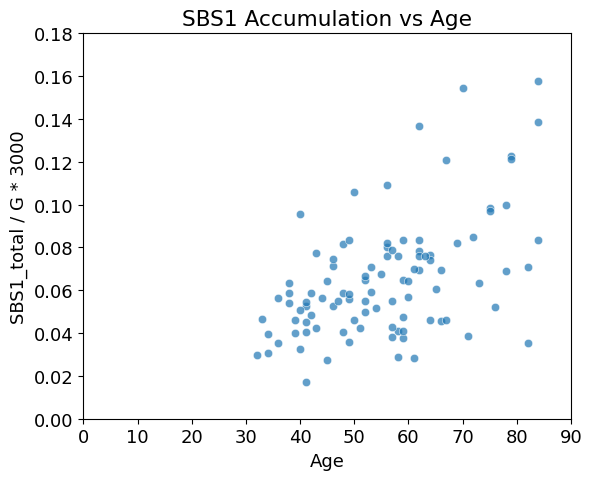

In [23]:
G_values = {sample_id: G(df) for sample_id, df in PCAWG_breast_samples.items()}
G_df = pd.DataFrame.from_dict(G_values, orient='index', columns=['G']).reset_index()
G_df.rename(columns={'index': 'aliquot_id'}, inplace=True)

# Merge with PCAWG_Metadata
PCAWG_Metadata = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/breast_ovarian_summary_with_age_hrd_grade.csv")
PCAWG_Metadata = PCAWG_Metadata[['aliquot_id', 'age', 'WGD','isHRD', 'organ.x']]
PCAWG_Metadata.rename(columns={'organ.x': 'organ'}, inplace=True)
PCAWG_Metadata = PCAWG_Metadata[(PCAWG_Metadata['WGD']==True) & (PCAWG_Metadata['organ']=='Breast')]
PCAWG_Metadata = PCAWG_Metadata.merge(G_df, on='aliquot_id', how='left')

base = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Breast/all_mut/SignatureFitting"
folders = {'Early': 'early', 'Late': 'late', 'NA': 'na'}

for p, s in folders.items():
    f = os.path.join(base, p, "exposures", "exposures_MuSiCal_lik.csv")
    if not os.path.exists(f): continue
    df = pd.read_csv(f, index_col=0)
    df.rename(columns={c: c.replace(f"_{s}", '') for c in df.columns if c.endswith(f"_{s}")}, inplace=True)
    sub = df.loc[['SBS1']].T
    sub.columns = [f'SBS1_{p}']
    sub.index.name = 'aliquot_id'
    PCAWG_Metadata = PCAWG_Metadata.merge(sub, on='aliquot_id', how='left')

PCAWG_Metadata['SBS1_total'] = PCAWG_Metadata[['SBS1_Early', 'SBS1_Late', 'SBS1_NA']].sum(axis=1)
PCAWG_Metadata['Cohort'] = "PCAWG"
PCAWG_Metadata['scaled_SBS1'] = PCAWG_Metadata['SBS1_total'] / (PCAWG_Metadata['G'] * 3000)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=PCAWG_Metadata, x='age', y='scaled_SBS1', alpha=0.7)
plt.ylim(0,0.18)
plt.xlim(0,90)
plt.xlabel("Age")
plt.ylabel("SBS1_total / G * 3000")
plt.title("SBS1 Accumulation vs Age")
plt.tight_layout()
plt.show()

# SCANB

In [24]:
vcf_folder_path = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25/Breast/all_mut"
SCANB_breast_samples = prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]


Processing Late samples:


Processing Files: 100%|██████████| 49/49 [00:14<00:00,  3.45it/s]


Processing NA samples:


Processing Files: 100%|██████████| 49/49 [00:17<00:00,  2.84it/s]


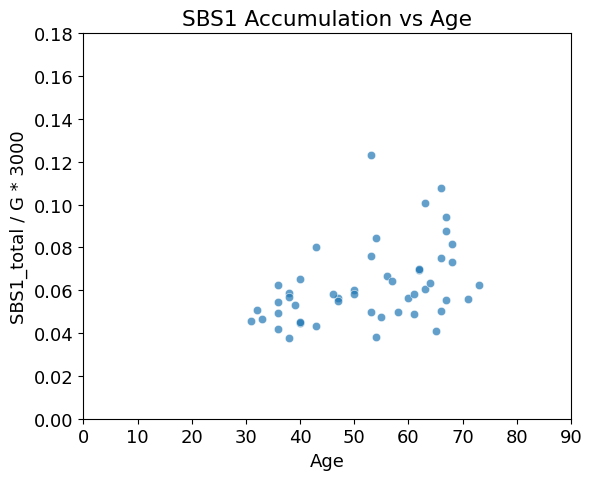

In [25]:
G_values = {sample_id: G(df) for sample_id, df in SCANB_breast_samples.items()}
G_df = pd.DataFrame.from_dict(G_values, orient='index', columns=['G']).reset_index()
G_df.rename(columns={'index': 'aliquot_id'}, inplace=True)

SCANB_Metadata = pd.read_csv("SCANB_metadata.csv")
SCANB_Metadata = SCANB_Metadata[['aliquot_id', 'Age', 'WGD', 'isHRD', 'organ']]
SCANB_Metadata.rename(columns={'Age': 'age'}, inplace=True)
SCANB_Metadata = SCANB_Metadata.merge(G_df, on='aliquot_id', how='left')

base = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25/Breast/all_mut/SignatureFitting"
folders = {'Early': 'early', 'Late': 'late', 'NA': 'na'}

for p, s in folders.items():
    f = os.path.join(base, p, "exposures", "exposures_MuSiCal_lik.csv")
    if not os.path.exists(f): continue
    df = pd.read_csv(f, index_col=0)
    df.rename(columns={c: c.replace(f"_{s}", '') for c in df.columns if c.endswith(f"_{s}")}, inplace=True)
    sub = df.loc[['SBS1']].T
    sub.columns = [f'SBS1_{p}']
    sub.index.name = 'aliquot_id'
    SCANB_Metadata = SCANB_Metadata.merge(sub, on='aliquot_id', how='left')

SCANB_Metadata['SBS1_total'] = SCANB_Metadata[['SBS1_Early', 'SBS1_Late', 'SBS1_NA']].sum(axis=1)
SCANB_Metadata['Cohort'] = "SCANB"
SCANB_Metadata['scaled_SBS1'] = SCANB_Metadata['SBS1_total'] / (SCANB_Metadata['G'] * 3000)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=SCANB_Metadata, x='age', y='scaled_SBS1', alpha=0.7)
plt.ylim(0,0.18)
plt.xlim(0,90)
plt.xlabel("Age")
plt.ylabel("SBS1_total / G * 3000")
plt.title("SBS1 Accumulation vs Age")
plt.tight_layout()
plt.show()

# INFORM

In [26]:
vcf_folder_path = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_INFORM_germline_filtered_v2/Breast/all_mut"
INFORM_breast_samples = prepare_samples_for_timing(vcf_folder_path)

Processing Early samples:


Processing Files: 100%|██████████| 19/19 [00:02<00:00,  6.72it/s]


Processing Late samples:


Processing Files: 100%|██████████| 19/19 [00:03<00:00,  4.77it/s]


Processing NA samples:


Processing Files: 100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


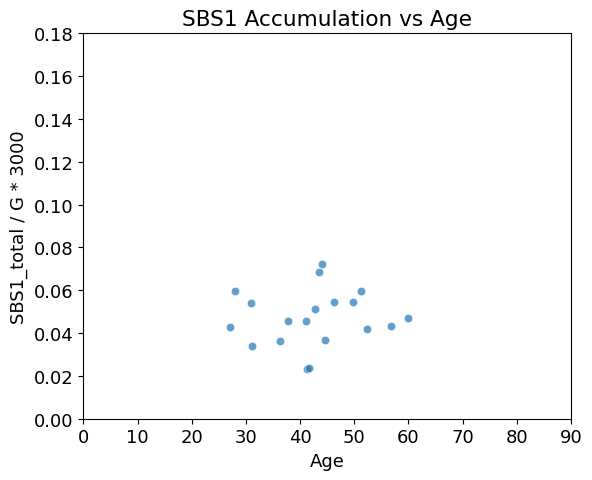

In [27]:
G_values = {sample_id: G(df) for sample_id, df in INFORM_breast_samples.items()}
G_df = pd.DataFrame.from_dict(G_values, orient='index', columns=['G']).reset_index()
G_df.rename(columns={'index': 'aliquot_id'}, inplace=True)

INFORM_Metadata_v1 = pd.read_csv('INFORM_metadata.csv')

INFORM_Metadata_v2 = pd.read_csv("clinical_data_deidentified_backup_Felipe_2021-02-08_annotated_2023_April30.txt", delimiter='\t')
INFORM_Metadata_v2['individual_display_title'] = 'Patient' +  INFORM_Metadata_v2['participant'].astype(str)
INFORM_Metadata_v2 = INFORM_Metadata_v2[['individual_display_title', 'age']]

INFORM_Metadata = INFORM_Metadata_v1.merge(INFORM_Metadata_v2, on='individual_display_title', how='inner')
INFORM_Metadata = INFORM_Metadata[['aliquot_id', 'age', 'WGD','isHRD', 'organ']]
INFORM_Metadata = INFORM_Metadata.merge(G_df, on='aliquot_id', how='left')

base = "/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_INFORM_germline_filtered_v2/Breast/all_mut/SignatureFitting"
folders = {'Early': 'early', 'Late': 'late', 'NA': 'na'}

for p, s in folders.items():
    f = os.path.join(base, p, "exposures", "exposures_MuSiCal_lik.csv")
    if not os.path.exists(f): continue
    df = pd.read_csv(f, index_col=0)
    df.rename(columns={c: c.replace(f"_{s}", '') for c in df.columns if c.endswith(f"_{s}")}, inplace=True)
    sub = df.loc[['SBS1']].T
    sub.columns = [f'SBS1_{p}']
    sub.index.name = 'aliquot_id'
    INFORM_Metadata = INFORM_Metadata.merge(sub, on='aliquot_id', how='left')

INFORM_Metadata['SBS1_total'] = INFORM_Metadata[['SBS1_Early', 'SBS1_Late', 'SBS1_NA']].sum(axis=1)
INFORM_Metadata['Cohort'] = "INFORM"
INFORM_Metadata['scaled_SBS1'] = INFORM_Metadata['SBS1_total'] / (INFORM_Metadata['G'] * 3000)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=INFORM_Metadata, x='age', y='scaled_SBS1', alpha=0.7)
plt.ylim(0,0.18)
plt.xlim(0,90)
plt.xlabel("Age")
plt.ylabel("SBS1_total / G * 3000")
plt.title("SBS1 Accumulation vs Age")
plt.tight_layout()
plt.show()

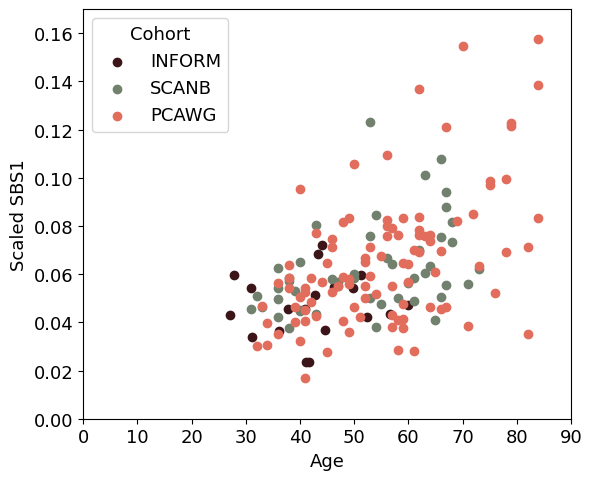

In [30]:
SBS1_acceleration_df = pd.concat([PCAWG_Metadata, SCANB_Metadata, INFORM_Metadata])
SBS1_acceleration_df.to_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/data/PCAWG_SCANB_INFORM_SBS1_Age_plot.csv")

colors = {'INFORM': '#3c1518', 'SCANB': '#71816d', 'PCAWG': '#e26d5c'}

fig, ax = plt.subplots(figsize=(6, 5))
for cohort, color in colors.items():
    df = SBS1_acceleration_df[SBS1_acceleration_df['Cohort'] == cohort]
    ax.scatter(df['age'], df['scaled_SBS1'], label=cohort, color=color)

ax.set_xlabel('Age')
ax.set_ylabel('Scaled SBS1')
ax.legend(title='Cohort')
plt.xlim(0, 90)
plt.ylim(0, 0.17)
plt.tight_layout()
plt.show()


# Include Normal Tissue Data

In [28]:
mutation_matrix = pd.read_csv('Japanese_data/vcfs/output/SBS/Input_vcffiles.SBS96.all', delimiter='\t', index_col=0)
catalog = musical.load_catalog('COSMIC_v3p2_SBS_WGS')
catalog.restrict_catalog(tumor_type='Breast.AdenoCA', is_MMRD=False, is_PPD=False)
W = catalog.W
W = W.reindex(mutation_matrix.index)
mutation_matrix = mutation_matrix.loc[:, (mutation_matrix != 0).any(axis=0)]
H, model = musical.refit.refit(mutation_matrix, W, method='likelihood_bidirectional', thresh=0.001)

In [29]:
norm_tissue_data = pd.read_csv("Japanese_Fig1.txt", delimiter='\t')

NormalTissueExposures = H.T
NormalTissueExposures['sample'] = NormalTissueExposures.index
NormalTissueExposures = NormalTissueExposures[['sample', 'SBS1']]
NormalTissueExposures = NormalTissueExposures.merge(norm_tissue_data, on='sample')
NormalTissueExposures['scaled_SBS1'] = NormalTissueExposures['SBS1'] / (2 * 3000)
NormalTissueExposures = NormalTissueExposures[NormalTissueExposures['group'] != 'BC (postmenopausal)']
NormalTissueExposures.to_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/data/NormalTissue_SBS1_Age_plot.csv")
NormalTissueExposures.head()

,sample,SBS1,case,group,age,driver,SNV number,indel number,scaled_SBS1
0,HV011-sc-1,141.033304,HV011,HV (premenopausal),36,None,715,51,0.023506
1,HV011-sc-2,80.326500,HV011,HV (premenopausal),36,None,597,43,0.013388
2,HV021-sc-1,83.547793,HV021,HV (premenopausal),30,None,490,30,0.013925
3,HV119-sc-1,49.529362,HV119,HV (premenopausal),34,None,393,22,0.008255
4,HV190-sc-1,73.163198,HV190,HV (premenopausal),37,None,675,43,0.012194


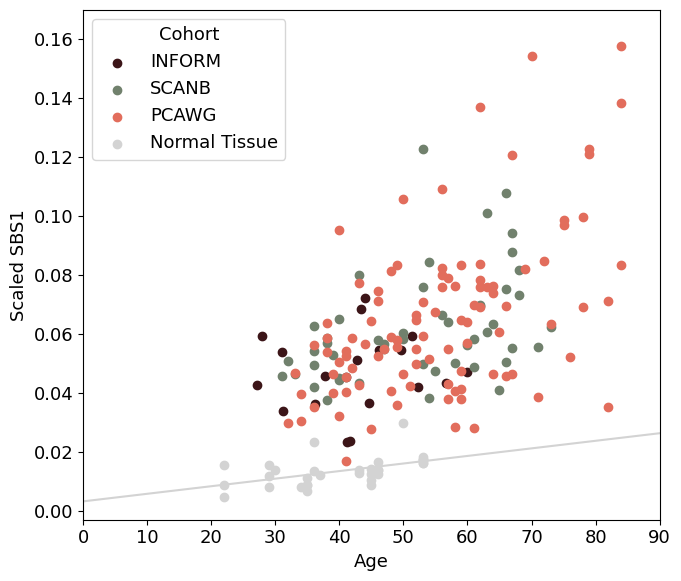

In [36]:
x = NormalTissueExposures['age']
y = NormalTissueExposures['scaled_SBS1']
slope, intercept, *_ = linregress(x, y)
x_fit = np.linspace(0, 90, 100)
y_fit = slope * x_fit + intercept

SBS1_acceleration_df = pd.concat([PCAWG_Metadata, SCANB_Metadata, INFORM_Metadata])
colors = {'INFORM': '#3c1518', 'SCANB': '#71816d', 'PCAWG': '#e26d5c'}

fig, ax = plt.subplots(figsize=(7, 6))
for cohort, color in colors.items():
    df = SBS1_acceleration_df[SBS1_acceleration_df['Cohort'] == cohort]
    ax.scatter(df['age'], df['scaled_SBS1'], label=cohort, color=color)

ax.scatter(x, y, color='lightgrey', label='Normal Tissue')
ax.plot(x_fit, y_fit, '-', color='lightgrey')

ax.set(xlabel='Age', ylabel='Scaled SBS1')
ax.legend(title='Cohort')
plt.xlim(0, 90)
plt.ylim(-0.003, 0.17)
plt.tight_layout()
plt.savefig("AAA_Apr25_plots/SBS1_Acceleration_Bulk.pdf", format='pdf', bbox_inches='tight')
plt.show()


# Sanger Data - Pre process and Analyze

In [44]:
import pandas as pd, os

def splitMutsPrimMet(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for f in os.listdir(input_folder):
        if f.endswith('.txt'):
            df = pd.read_csv(os.path.join(input_folder, f), sep='\t')
            prefix = f.split('_dirichlet')[0]
            cols = ['Chrom', 'Pos', 'ID', 'Ref', 'Alt', 'nMin1.a', 'nMin2.a', 'nMin1.c', 'nMin2.c', 'nMaj1.a', 'nMaj2.a', 'nMaj1.c', 'nMaj2.c']
            for c in cols: df[c] = df.get(c, '.')
            df['INFO'] = df.apply(lambda r: ';'.join(f"{k}={r[k]}" for k in cols[5:]), axis=1)
            df = df[['Chrom', 'Pos', 'ID', 'Ref', 'Alt', 'INFO', 'timing']]
            for labels, suffix in [(['SHARED', 'PRIM_ONLY'], 'shared_prim'), (['SHARED', 'MET_ONLY'], 'shared_met')]:
                sub = df[df['timing'].isin(labels)]
                with open(os.path.join(output_folder, f"{prefix}_{suffix}.vcf"), 'w') as out:
                    out.write('##fileformat=VCFv4.2\n#CHROM\tPOS\tID\tREF\tALT\tINFO\n')
                    sub.to_csv(out, sep='\t', header=False, index=False)

In [45]:
input_folder = 'SangerData'
output_folder = 'AA_SangerData_PostProcess/vcfs'
splitMutsPrimMet(input_folder='SangerData',
                 output_folder=output_folder)

In [46]:
Analyze.cosmic_fit("AA_SangerData_PostProcess/vcfs",
                   "AA_SangerData_PostProcess/vcfs" + '/SigProfiler/', 
                   input_type="vcf", context_type="96",
                   collapse_to_SBS96=False, cosmic_version=3.2, exome=False,
                   genome_build="GRCh37",
                   exclude_signature_subgroups=None, export_probabilities=False,
                   export_probabilities_per_mutation=False, make_plots=False,
                   sample_reconstruction_plots=False, verbose=False)

Starting matrix generation for SNVs and DINUCs...Completed! Elapsed time: 4.12 seconds.
Matrices generated for 34 samples with 0 errors. Total of 221439 SNVs, 896 DINUCs, and 0 INDELs were successfully analyzed.
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 34/34 [100%] in 16.0s (2.13/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


In [37]:
mutation_matrix = pd.read_csv('AA_SangerData_PostProcess/vcfs/output/SBS/Input_vcffiles.SBS96.all', delimiter='\t', index_col=0)
catalog = musical.load_catalog('COSMIC_v3p2_SBS_WGS')
catalog.restrict_catalog(tumor_type='Breast.AdenoCA', is_MMRD=False, is_PPD=False)
W = catalog.W
W = W.reindex(mutation_matrix.index)
mutation_matrix = mutation_matrix.loc[:, (mutation_matrix != 0).any(axis=0)]
H_Mets, model_Mets = musical.refit.refit(mutation_matrix, W, method='likelihood_bidirectional', thresh=0.001)

In [38]:
Mets_Metadata = pd.read_csv("SangerPaperData.txt", delimiter='\t')
Mets_Metadata['Relapse age'] = Mets_Metadata['Primary_age'] + Mets_Metadata['Relapse_time'] 
Mets_Metadata['Norm_Prim_CpG'] = Mets_Metadata['Primary_CpG_muts'].div(Mets_Metadata['Primary_ploidy'] * 3000)
Mets_Metadata['Norm_Rel_CpG'] = Mets_Metadata['Relapse_CpG_muts'].div(Mets_Metadata['Relapse_ploidy'] * 3000)

In [39]:
def addSBS1ToMetadata(df1, df2):
    df = pd.merge(df1, df2, left_on='ID', right_index=True, how='left')
    for i, r in df.iterrows():
        for t in ['prim', 'met']:
            for s in ['SBS1']:
                col = f"{r['ID']}_shared_{t}"
                if col in df2.columns:
                    df.at[i, f"{s}_{t}"] = df2.at[s, col]
    df.drop(columns=[c for c in df2.columns if '_prim' in c or '_met' in c], inplace=True)
    return df

Mets_Metadata = addSBS1ToMetadata(Mets_Metadata, H_Mets)

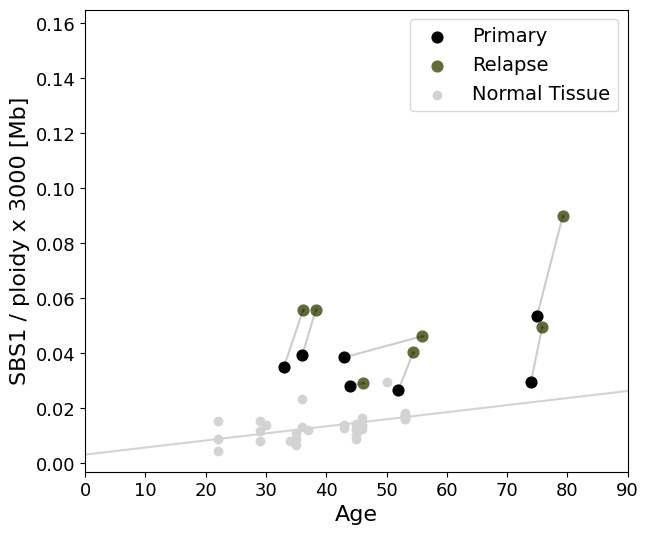

In [40]:
Mets_Metadata['scaled_Prim_SBS1'] = Mets_Metadata['SBS1_prim'] / (Mets_Metadata['Primary_ploidy'] * 3000)
Mets_Metadata['scaled_Rel_SBS1'] = Mets_Metadata['SBS1_met'] / (Mets_Metadata['Relapse_ploidy'] * 3000)
Mets_Metadata = Mets_Metadata.drop(columns=['Acc_CpG', 'Acc_max', 'Acc_min', 'Primary_effGenome'])
Mets_Metadata.to_csv("AAA_Apr25_plots/data/Metastasis_SBS1_Age_plot.csv")

mpl.rcParams['pdf.fonttype'] = 42

NormalTissueExposures = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/data/NormalTissue_SBS1_Age_plot.csv")
x = NormalTissueExposures['age']
y = NormalTissueExposures['scaled_SBS1']
slope, intercept, *_ = linregress(x, y)
x_fit = np.linspace(0, 90, 100)
y_fit = slope * x_fit + intercept

plt.figure(figsize=(7, 6))
for _, r in Mets_Metadata.iterrows():
    plt.plot([r['Primary_age'], r['Relapse age']], [r['scaled_Prim_SBS1'], r['scaled_Rel_SBS1']], c="k", alpha=0.2, marker='o', markersize=1)
plt.scatter(Mets_Metadata['Primary_age'], Mets_Metadata['scaled_Prim_SBS1'], s=60, color='k', label='Primary')
plt.scatter(Mets_Metadata['Relapse age'], Mets_Metadata['scaled_Rel_SBS1'], s=60, color='#606c38', label='Relapse')
plt.scatter(x, y, color='lightgrey', label='Normal Tissue')
plt.plot(x_fit, y_fit, '-', color='lightgrey')
plt.xlabel('Age', fontsize=16)
plt.ylabel('SBS1 / ploidy x 3000 [Mb]', fontsize=16)
plt.xlim(0, 90)
plt.ylim(-0.003, 0.165)
plt.legend(fontsize=14)
plt.savefig("AAA_Apr25_plots/SBS1_Acceleration_Mets.pdf", format='pdf', bbox_inches='tight')
plt.show()
